In [28]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Relevant Dataset

In [29]:
weather_df = pd.read_csv('../B_Processed_Data/Processed_WeatherData.csv', index_col=0, parse_dates=True).reset_index()
news_df = pd.read_csv('../B_Processed_Data/Processed_NewsData.csv')
production_df = pd.read_csv('../B_Processed_Data/Processed_CPO_Production.csv')
price_df = pd.read_csv('../B_Processed_Data/Processed_investing_Bursa_CPO_price.csv', index_col=0, parse_dates=True).reset_index()


__Weather Data__
* 106 of weather data from weather stations in Malaysia, Indonesia, and Singapore were selected based on proximity to Palm Oil Plantations.
* Data are crawled from <https://en.tutiempo.net>


In [30]:
weather_df = weather_df.iloc[:, :-7]
weather_df.head()

,Day,country,location,station_id,latitude,longitude,T,TM,Tm,H,PP
0,2010-01-01,indonesia,Alor / Mali,ws-973200,-8.21,124.56,29.1,32.2,25.0,84.0,0.000000
1,2010-01-02,indonesia,Alor / Mali,ws-973200,-8.21,124.56,28.7,31.6,24.4,80.0,0.000000
2,2010-01-03,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.8,32.4,24.3,84.0,0.510000
3,2010-01-04,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.2,30.8,23.6,87.0,3.209091
4,2010-01-05,indonesia,Alor / Mali,ws-973200,-8.21,124.56,25.8,27.8,23.8,96.0,67.820000


__News Data__
* News data crawled from <www.theedgemarkets.com> using 'Palm Oil' as search keyword.
* Sentiment Analysis will be performed on news title only

In [31]:
news_df.drop('news_content', axis=1, inplace=True)
news_df.head()

,news_title,news_date_update
0,"AirAsia X, Alliance, Berjaya Corp, CIMB, Desti...",29 February 2020
1,Sime Darby Plantation: COVID-19 has dried up p...,28 February 2020
2,Commodities savaged in sell-off as coronavirus...,28 February 2020
3,TDM gets RM210m offer for two loss-making Indo...,28 February 2020
4,"No planned divestment of MSM stake, says FGV",28 February 2020


__CPO Production Data__
* Monthly Malaysia CPO production from 2014 to 2020. Data Source: http://mpoc.org.my/monthly-palm-oil-trade-statistics-2014/

In [32]:
production_df.head()

,Month Year,Production
0,Jan 2019,1737461
1,Feb 2019,1544518
2,Mar 2019,1672058
3,Apr 2019,1649368
4,May 2019,1671467


__CPO Price MYR__
* Daily Trading Days CPO Prices on Bursa Malaysia market crawled from <https://investing.com>
* CPO price in MYR currency is used to minimize forex effects 

In [33]:
price_df = price_df.sort_values('Date')
price_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
1360,2014-08-18,2099.0,2105.0,2112.0,2096.0,1.04,-3.09
1359,2014-08-19,2074.0,2107.0,2107.0,2074.0,0.86,-1.19
1358,2014-08-20,2054.0,2078.0,2078.0,2051.0,0.56,-0.96
1357,2014-08-21,2055.0,2070.0,2070.0,2044.0,0.92,0.05
1356,2014-08-22,2021.0,2063.0,2063.0,2020.0,1.24,-1.65


# Data Wrangling 

__Rename Weather Data Day column to Date__

In [34]:
weather_df = weather_df.rename(columns={'Day':'Date'})

__Standardize Production monthly data timestamp and datatype__

In [35]:
production_df['Date'] = pd.to_datetime(production_df['Month Year'])
production_df = production_df.drop('Month Year', axis=1)
production_df.head()

,Production,Date
0,1737461,2019-01-01
1,1544518,2019-02-01
2,1672058,2019-03-01
3,1649368,2019-04-01
4,1671467,2019-05-01


__Convert date colume to correct datetime type__

In [36]:
news_df['Date'] = pd.to_datetime(news_df['news_date_update'])

__Remove any data prior to 2014 August for weather data and news data since our CPO price dataset only starts there__

In [37]:
weather_df = weather_df[weather_df['Date']>'2014-08']
production_df = production_df[production_df['Date']>'2014-08']
news_df = news_df[news_df['Date']>'2014-08']

# Exploration

### Let's first look at CPO PRICE

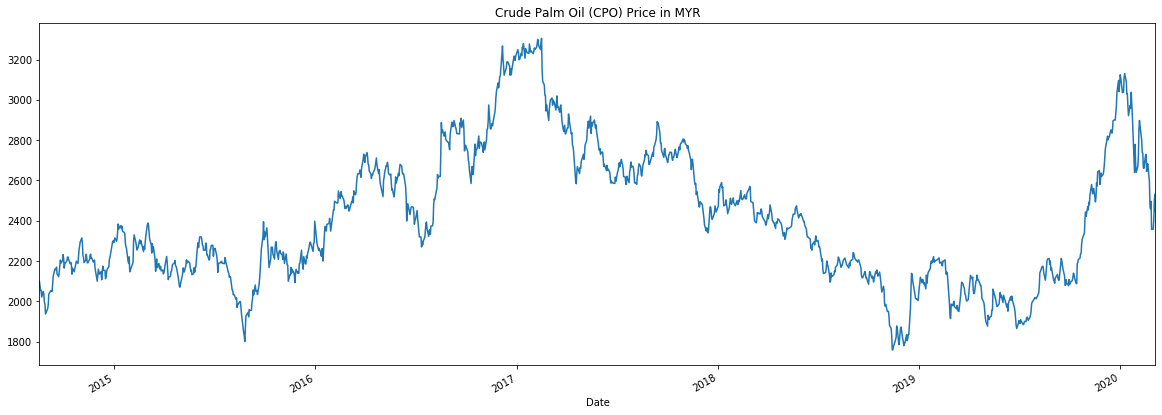

In [38]:
fig, ax = plt.subplots(figsize = (20,7))
price_df.set_index('Date')['Price'].plot(ax=ax)
plt.title('Crude Palm Oil (CPO) Price in MYR')
plt.show()

### Then  look at CPO Production

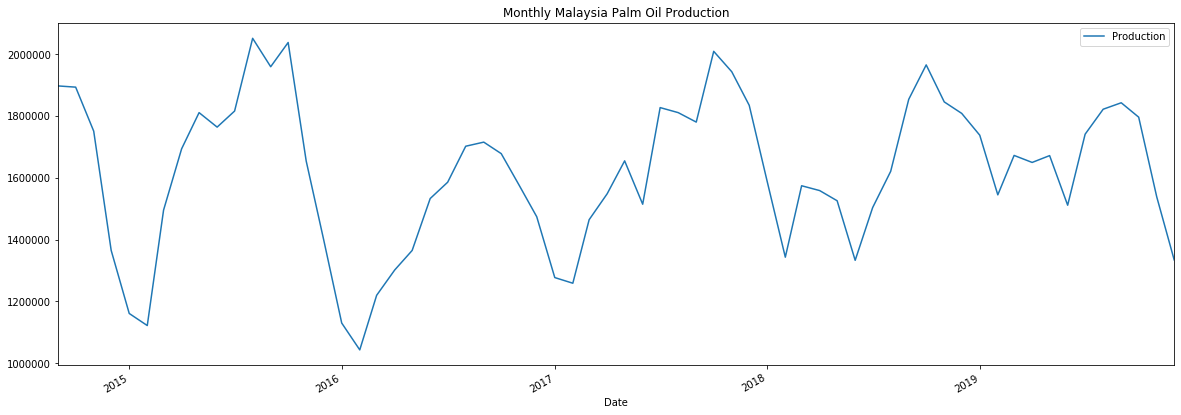

In [39]:
fig, ax = plt.subplots(figsize = (20,7))
production_df.set_index('Date').plot(ax=ax)
plt.title('Monthly Malaysia Palm Oil Production')
plt.show()

### And look at weather data
These are data from 106 weather stations in Malaysia, Indonesia and Singapore. We will only look at 5 main attributes:

    1) 'T' : 'Average Temperature (°C)'
    2) 'TM': 'Maximum temperature (°C)'
    3) 'Tm': 'Minimum temperature (°C)'
    4) 'H' : 'Average relative humidity (%)'
    5) 'PP': 'Total rainfall and / or snowmelt (mm)'

__PP: Total rainfall and / or snowmelt (mm)__
<br>The data for total rainfall is highly skewed with many centered around zero. We will need additionaly transformation to normalize this data

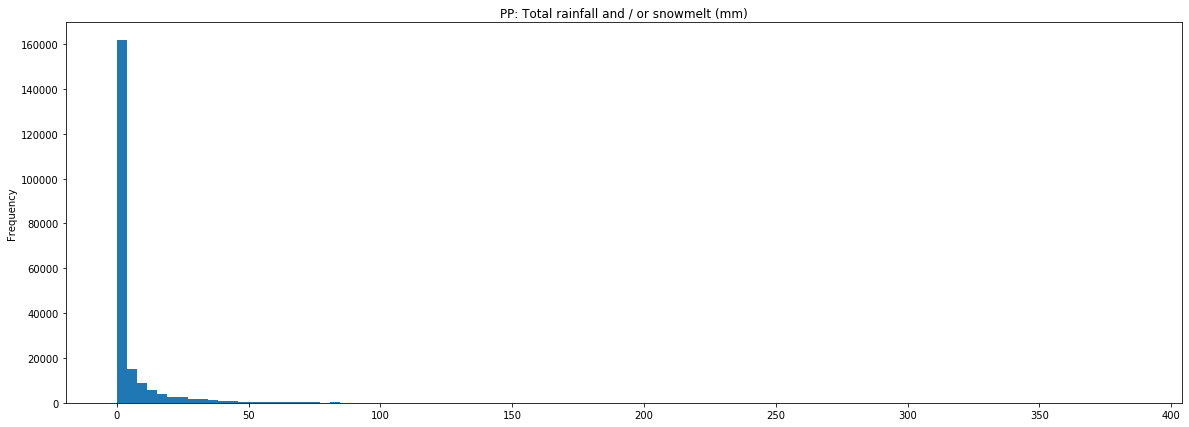

In [40]:
fig, ax = plt.subplots(figsize = (20,7))
weather_df['PP'].plot(kind='hist', bins=100, ax=ax)
plt.title('PP: Total rainfall and / or snowmelt (mm)')
plt.show()

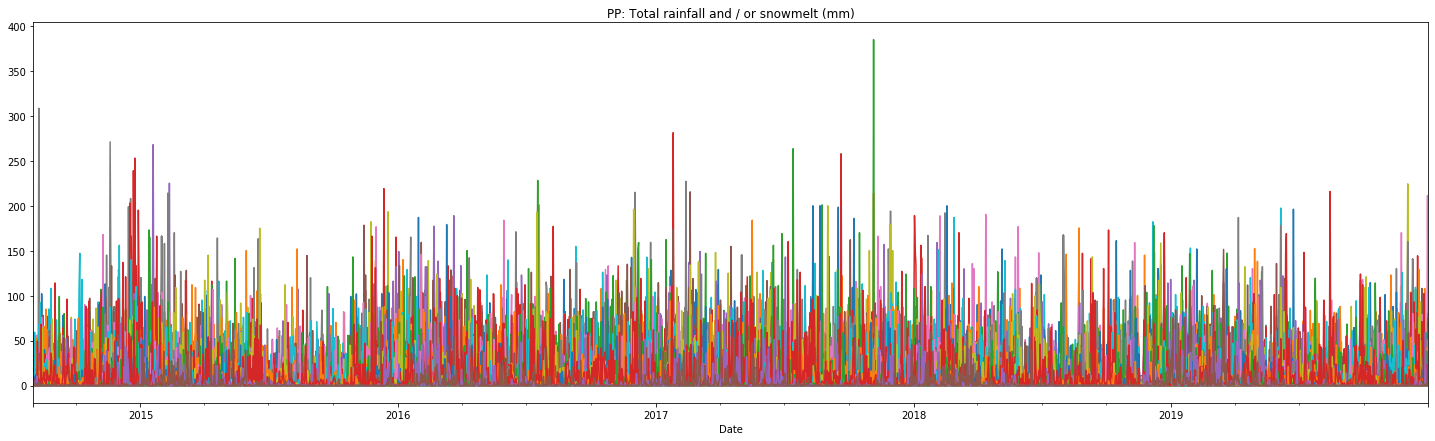

In [41]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['PP'].plot(ax=ax)
plt.title('PP: Total rainfall and / or snowmelt (mm)')
plt.show()

__Temperature Data__
* Temperature data looks reasonable for all weather stations with exception of maybe a few peaks close to 5 degree C in 'Tm' for Minimum Temperature in Enarotali, Papua. 
* Seasonality can be observed

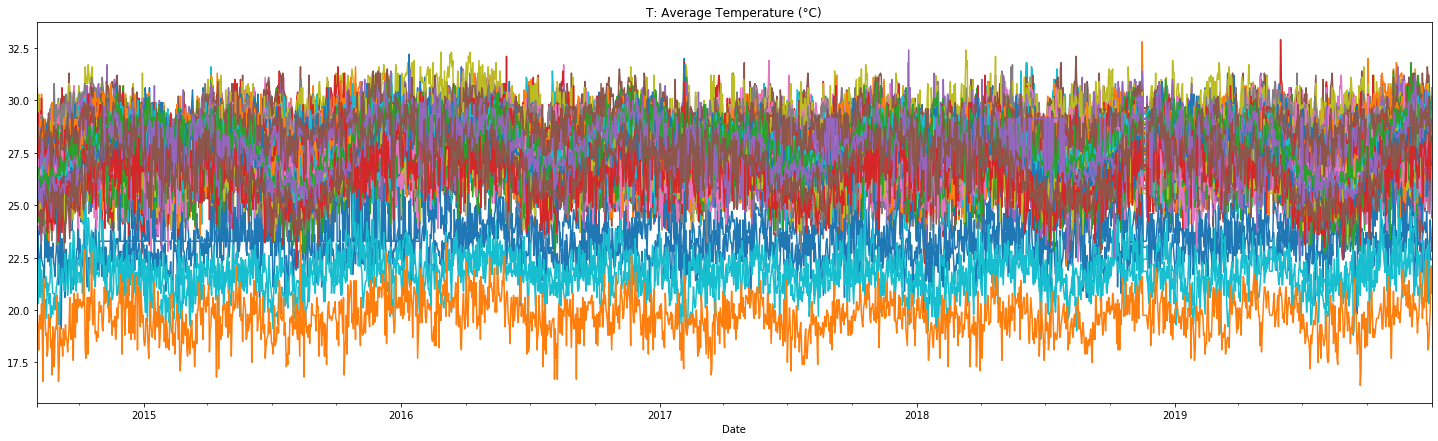

In [42]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['T'].plot()
plt.title('T: Average Temperature (°C)')
plt.show()

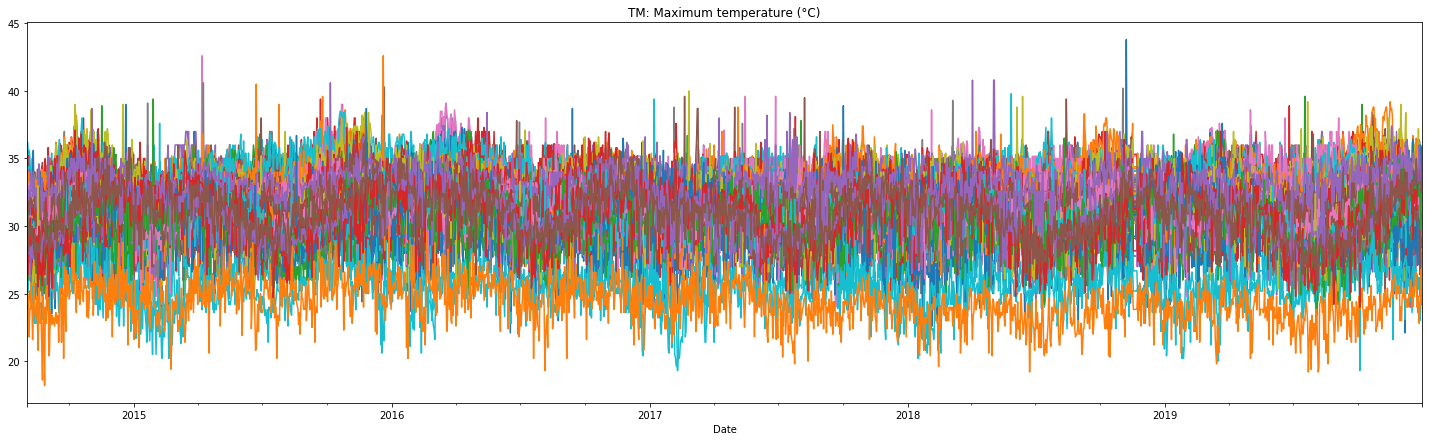

In [43]:
fig, ax = plt.subplots(figsize = (25, 7))
weather_df.set_index('Date').groupby('station_id')['TM'].plot()
plt.title('TM: Maximum temperature (°C)')
plt.show()

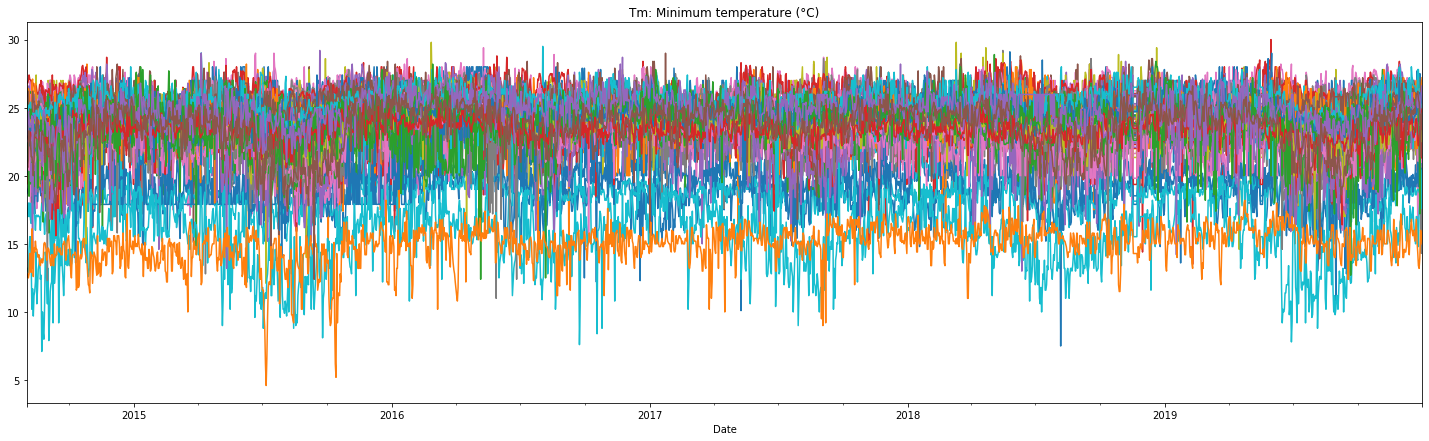

In [44]:
fig, ax = plt.subplots(figsize = (25, 7))
weather_df.set_index('Date').groupby('station_id')['Tm'].plot()
plt.title('Tm: Minimum temperature (°C)')
plt.show()

__H: Average relative humidity (%)'__
* Humidity looks reasonable with expected seasonality similarly seen from temperature data

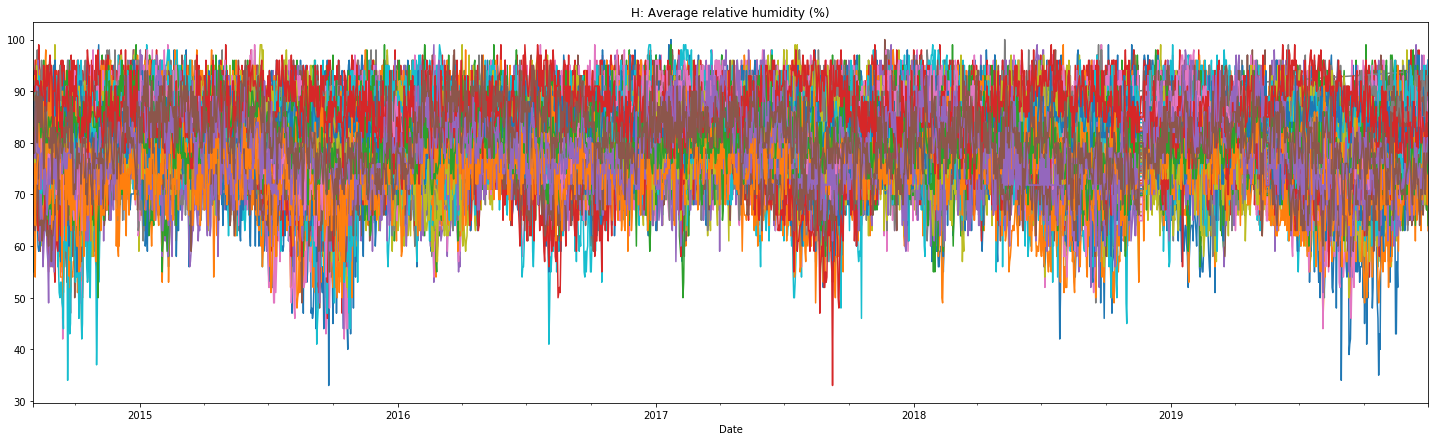

In [45]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['H'].plot()
plt.title('H: Average relative humidity (%)')
plt.show()

# Feature Transformation

__Compute CPO Price returns on longer timeframe__

In [46]:
price_df['Change %_10T'] = price_df['Price'].pct_change(10).shift(-10)
price_df['Change %_20T'] = price_df['Price'].pct_change(20).shift(-20)
price_df['Change %_30T'] = price_df['Price'].pct_change(30).shift(-30)
price_df.dropna(inplace=True)

__Compute CPO Price Simple Moving Average as a feature__

In [47]:
price_df['Price_MAV20'] = price_df['Price'].rolling(20, min_periods=1).mean()

__Scale column 'PP' in weather data using log(x+1)__
* This will make larger values smaller and easier to normalize

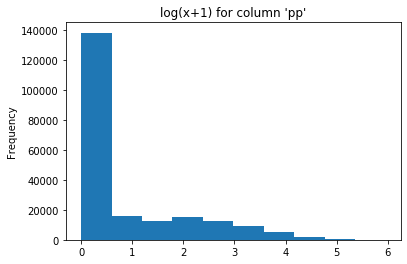

In [48]:
weather_df['PP'] = weather_df['PP'].apply(lambda x: math.log(x+1))
weather_df['PP'].plot(kind='hist')
plt.title("log(x+1) for column 'pp'")
plt.show()

__Normalize Weather Data and Pivot Tables__

In [85]:
from sklearn.preprocessing import StandardScaler
weather_scaler = StandardScaler()

In [92]:
weather_df.head()

,Date,country,location,station_id,latitude,longitude,T,TM,Tm,H,PP
1674,2014-08-02,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.1,30.3,21.0,72.0,0.0
1675,2014-08-03,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.3,31.5,20.1,72.0,0.0
1676,2014-08-04,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.2,32.0,21.2,72.0,0.0
1677,2014-08-05,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.4,31.5,18.5,66.0,0.0
1678,2014-08-06,indonesia,Alor / Mali,ws-973200,-8.21,124.56,27.0,31.6,21.9,66.0,0.0


In [93]:
weather_df.iloc[:,-5:-1] = weather_scaler.fit_transform(weather_df.iloc[:,-5:-1])

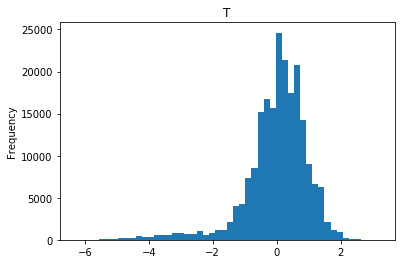

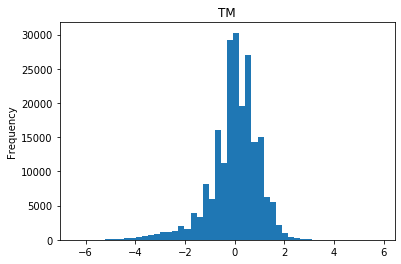

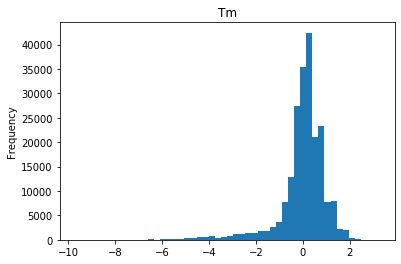

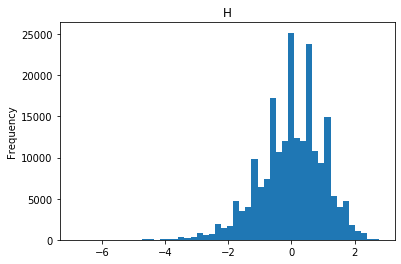

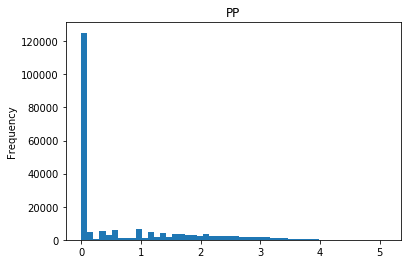

In [95]:
w_attributes = weather_df.iloc[:,-5:].columns


for col in w_attributes:
    weather_df[col].plot(kind='hist', bins=50)
    plt.title(col)
    plt.show()

In [89]:
weather_df['PP'] 

1674      0.000000
1675      0.000000
1676      0.000000
1677      0.000000
1678      0.000000
            ...   
385136    0.000000
385137    0.000000
385138    0.853562
385139    1.792660
385140    0.000000
Name: PP, Length: 210643, dtype: float64

__Perform sentiment analysis using VaderSentiment__
<br>1) We need to infer sentiment value on news titles. In order to do this we will use VaderSentiment

In [22]:
# !pip install vaderSentiment

In [23]:
# Use VaderSentiment to perform sentiment analysis on news title
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vader_df = pd.DataFrame([row for row in news_df['news_title'].apply(lambda x: analyzer.polarity_scores(x))])


# Concat date with result, and aggregate mean sentiment score by date
sentiment_df = pd.concat([news_df['Date'], vader_df], axis=1)
sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

sentiment_df.head()

,Date,neg,neu,pos,compound
0,2014-08-29,0.000000,1.000000,0.000000,0.000000
1,2014-09-02,0.352000,0.437000,0.211000,-0.446600
2,2014-09-03,0.291000,0.709000,0.000000,-0.571900
3,2014-09-04,0.155000,0.845000,0.000000,-0.296000
4,2014-09-05,0.074429,0.784857,0.140714,0.098186


# Merge all data into one dataframe

__Merge CPO Price with News Sentiment__

In [27]:
merge_df = pd.merge(price_df, sentiment_df, how='left', on='Date')
merge_df = merge_df[(merge_df['Date']<'2020') & (merge_df['Date']>'2014-09')]

# forward fill the sentiment if any na
merge_df[['neg', 'neu', 'pos', 'compound']] = merge_df[['neg', 'neu', 'pos', 'compound']].ffill()
display(merge_df)

,Date,Price,Open,High,Low,Vol.,Change %,Change %_10T,Change %_20T,Change %_30T,Price_MAV20,neg,neu,pos,compound
10,2014-09-02,1964.0,1930.0,1964.0,1930.0,0.12,1.39,0.097760,0.125255,0.087067,2024.363636,0.352000,0.437000,0.211000,-0.446600
11,2014-09-03,1984.0,1970.0,1990.0,1962.0,0.57,1.02,0.093750,0.091230,0.091230,2021.000000,0.291000,0.709000,0.000000,-0.571900
12,2014-09-04,2035.0,1982.0,2027.0,1980.0,0.31,2.57,0.049631,0.074693,0.055037,2022.076923,0.155000,0.845000,0.000000,-0.296000
13,2014-09-05,2041.0,2050.0,2050.0,2036.0,0.02,0.29,0.040176,0.078883,0.057815,2023.428571,0.074429,0.784857,0.140714,0.098186
14,2014-09-08,2054.0,2070.0,2076.0,2050.0,0.05,0.64,0.047712,0.080818,0.063778,2025.466667,0.023625,0.902375,0.074000,0.091125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2019-12-24,2900.0,2901.0,2907.0,2890.0,0.50,-0.03,0.071724,0.029310,-0.009655,2771.000000,0.155000,0.739500,0.105500,-0.099050
1311,2019-12-26,2969.0,2910.0,2970.0,2910.0,0.20,2.38,0.054564,-0.014820,-0.056922,2789.450000,0.000000,0.463000,0.537000,0.700300
1312,2019-12-27,3035.0,3010.0,3058.0,3006.0,0.26,2.22,0.018781,-0.130148,-0.097199,2809.350000,0.000000,0.740000,0.260000,0.409950
1313,2019-12-30,3097.0,3015.0,3100.0,3010.0,0.36,2.04,-0.021634,-0.102680,-0.116564,2833.200000,0.020857,0.888286,0.090857,0.113157


__Merge Weather Data with the previous merged dataframe__

In [25]:
merge_df = pd.merge(merge_df, weather_df2, how='left', on='Date')

NameError: name 'weather_df2' is not defined

In [ ]:
merge_df.set_index('Date', inplace=True)
merge_df

# Hypothesis
* Weather data significantly affect / correlate to palm oil production yield
* Weather data significantly affect / correlate to CPO commodity prices
* Palm oil industry related news sentiment significantly affect / correlate to CPO commodity prices

In [ ]:
sns.pairplot(merge_df.iloc[:,5:])